# Followed By Trigger Language Analysis

This analysis has been done in context of the following constraints:

-  FollowedBy Classifier is a citation level classifier - As such, given a citation, it is able to classify it as 'Followed By' or 'Not Followed By'

-  A citation is followed if it is treated with one of the letters in ('#&ff', '#ff', '&ff', 'ff', '#&f', '#f', '&f', 'f'). However, for the purpose of classifier, all these letters are treated the same. 

Trigger language is captured using a group where each group may have fragments scattered across different paragraphs within a document. Referenced cites may appear in the trigger language paragraphs or outside of such paragraphs. Multiple cites may be referenced within a fragment. A paragraph with trigger language may have collection of cites where a cite may have been followed but not all the cites.

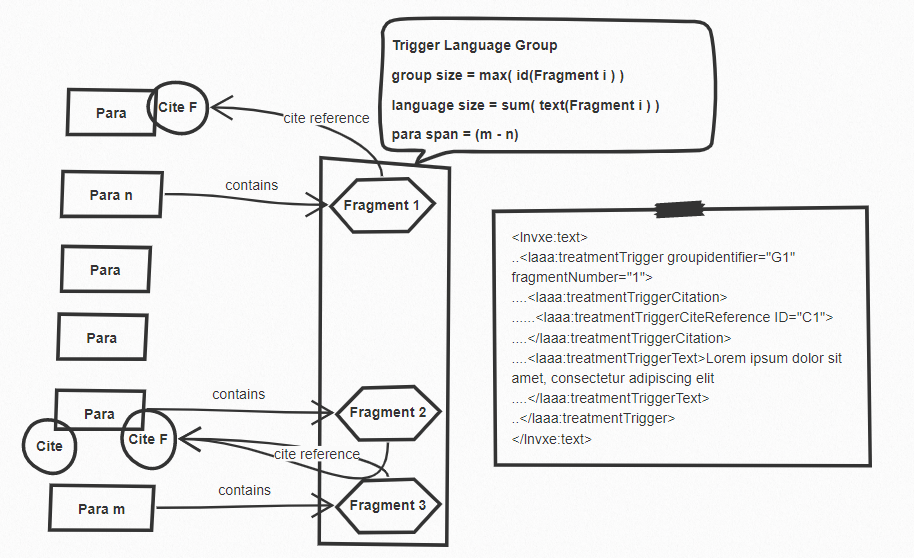

## Extract data from followed-by trigger language files
Files with trigger laguage are located in \\\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\HasTriggerLanguage
<br/>
Files that have no trigger language are located in \\\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\NoTriggerLanguage
<br/>

In [1]:
import glob
tl_files = glob.glob(r'\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\HasTriggerLanguage\*.xml')
nt_files = glob.glob(r'\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\NoTriggerLanguage\*.xml')

### Use regex to find top level paragraph and trigger elements 
It is expensive to create DOM for the entire document as some documents may not have trigger language. The approach is to break the document into top level paragraph text fragments and then locate trigger language in each fragment. If trigger language is located, DOM is created for the paragraph fragment.

In [2]:
import re

trigger = re.compile(r'(<laaa:treatmentTrigger.*</laaa:treatmentTrigger>)')

def find_trigger(s):  
    '''Find trigger elements in given text fragment'''
    return trigger.findall(s)

paragph = re.compile(r'(<lnvxe:text>.*?</lnvxe:text>)')

def find_paragph(s): 
    '''Find top level paragraph elements in given text fragment'''
    return paragph.findall(s)

### Encode editor id

In [3]:
editor_alias = '@'

editors = {}

def get_editor_alias(editor_id):
  if not editors.get(editor_id, ''):
        global editor_alias
        editor_alias = chr(ord(editor_alias) + 1)
        editors[editor_id] = editor_alias
  return editors[editor_id]

### Parse document using lxml etree

In [4]:
from lxml import etree as ElementTree


def xml_to_tree(fragment):
    '''Return ElementTree for given xml text'''
    namespaces = {'laaa':'http://www.w3.org/laaa', 'lnci':'http://www.w3.org/lnci', 'lnvxe':'http://www.w3.org/lnvxe' }
    ns = ' '.join(('xmlns:{}="{}"'.format(*i) for i in namespaces.items()))
    xml = '<doc {}>{}</doc>'.format(ns, fragment)
    tree = ElementTree.fromstring(xml)
    return tree, namespaces


def find_element_attributes(tag, attr, value, fragment):
    '''
    Return attribute list of the first element based on tag and attribute value.
    '''
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.xpath(".//{}[@{}='{}']".format(tag, attr, value), namespaces=namespaces)
    attributes = elements[0].attrib if elements else []
    return attributes

def find_descendants(tag, tree, namespaces):
    '''
    Return descendant elements based on tag and attribute value.
    '''
    elements = tree.xpath(".//{}".format(tag), namespaces=namespaces)
    return elements


def embedded_cite(id, fragment):
    '''Return True if given text contains a lnci:cite element with ID attribute = id'''
    attributes = find_element_attributes('lnci:cite', 'ID', id, fragment)
    return True if attributes else False


def find_cite_references(fragment):
    '''Return list of cite id referenced by treatment trigger in given xml text'''
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.findall('.//laaa:treatmentTriggerCiteReference', namespaces=namespaces)
    references = [e.attrib['ID'] for e in elements]
    return references


def find_case_references(fragment):
    '''Return list of case reference id in given xml text'''
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.findall('.//lnci:caseref', namespaces=namespaces)
    references = [e.attrib['ID'] for e in elements]
    return references


def find_cites(fragment):
    '''Return list of tuples (cite_id, treatment_letter, is_anaphoric_ref) in given xml text'''
    def cite_letter(elements):
        letters = [e.attrib['letter'] for e in elements]
        return letters[0] if letters else None
    def anaphoric_ref(element):
        anaphref = element.attrib.get('anaphref')
        return anaphref
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.xpath('.//lnci:cite', namespaces=namespaces)
    anapr = [anaphoric_ref(e) for e in elements]
    lettr = [cite_letter(find_descendants('lnci:editletter', e, namespaces)) for e in elements]
    cites = [e.attrib['ID'] for e in elements]
    descr = [''.join(e.itertext()) for e in elements]
    return list(zip(cites, lettr, anapr, descr))

def find_trigger_sections(fragment):
    def remove_nested_trigger(e, ns):
        language = ''.join(e.itertext())        
        _ = [t.xpath('..')[0].remove(t) for t in e.xpath('./laaa:treatmentTriggerText', namespaces=ns)]
        trigger_text_tag = '{http://www.w3.org/laaa}treatmentTriggerText'
        trigger_text_element = ElementTree.SubElement(e, trigger_text_tag)
        trigger_text_element.text = language
        return e
    '''
    Return list of laaa:treatmentTrigger xml content as a string
    laaa:treatmentTrigger can have nested laaa:treatmentTrigger elements, remove them and include 
    laaa:treatmentTriggerText that has the actual treatment text.
    ElementTree.tostring(...) returns trailing text after the end tag, so use regex to clean the xml string.
    '''
    if not find_trigger(fragment):
        return []
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.xpath('.//laaa:treatmentTrigger', namespaces=namespaces)
    elements = [remove_nested_trigger(e, namespaces) for e in elements]
    sections = [ElementTree.tostring(e, method='xml', encoding='utf-8').decode() for e in elements]
    return sections

def find_trigger_section(fragment):
    '''
    Return top level laaa:treatmentTrigger xml content as a string
    laaa:treatmentTrigger can have nested laaa:treatmentTrigger elements, return only top level elements.
    Nested laaa:treatmentTrigger has laaa:treatmentTriggerText as parent.
    ElementTree.tostring(...) returns trailing text after the end tag, so use regex to clean the xml string.
    '''
    if not find_trigger(fragment):
        return []
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.xpath('.//laaa:treatmentTrigger', namespaces=namespaces)
    trigger_text_tag = '{http://www.w3.org/laaa}treatmentTriggerText'
    elements = [e for e in elements if e.xpath('..')[0].tag != trigger_text_tag]
    sections = [ElementTree.tostring(e, method='xml', encoding='utf-8').decode() for e in elements]
    sections = [find_trigger(s)[0] for s in sections]
    return sections

def find_trigger_language(fragment):
    '''
    Return all the text embedded within laaa:treatmentTriggerText elements in given laaa:treatmentTrigger xml string 
    '''
    namespaces = {'laaa':'http://www.w3.org/laaa', 'lnci':'http://www.w3.org/lnci', 'lnvxe':'http://www.w3.org/lnvxe' }
    parser = ElementTree.XMLParser(recover=True)
    root = ElementTree.fromstring(fragment, parser)
    elements = root.findall('.//', namespaces)
    trigger_elements = [e for e in elements if e.tag == '{http://www.w3.org/laaa}treatmentTriggerText']
    language = ''.join(trigger_elements[0].itertext())
    group_id = root.attrib['groupIdentifier']
    fragment_id = root.attrib['fragmentNumber']
    editor_id = root.attrib['editorId']
    return language, group_id, fragment_id, get_editor_alias(editor_id)


def get_text(fragment):
    '''Return all the text within given xml string'''
    tree, namespaces = xml_to_tree(fragment)
    return ''.join(tree.itertext())

### Description of DataFrame Columns 

<table style="float:left">
        <tr>
            <th style="text-align:left;">Name</td>
            <th style="text-align:left;">Description</td>
        </tr>
        <tr>
            <td style="text-align:left;">para_element</td>
            <td style="text-align:left;">xml with root element &lt;lnvxe:text&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">para_text</td>
            <td style="text-align:left;">paragraph text</td>
        </tr>
        <tr>
            <td style="text-align:left;">trgr_element</td>
            <td style="text-align:left;">xml with root element &lt;laaa:treatmentTrigger&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">trgr_language</td>
            <td style="text-align:left;">text contained in element &lt;laaa:treatmentTrigger&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_in_para</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_in_para_anaphref</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element that have anaphref attribute</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_f_letter_cite_in_para</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element that have letter f</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_nonf_letter_cite_in_para</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element that have treatment letter other than f</td>
        </tr>        
        <tr>
            <td style="text-align:left;">cnt_cite_referenced</td>
            <td style="text-align:left;">number of &lt;laaa:treatmentTriggerCiteReference&gt; elements within &lt;laaa:treatmentTrigger&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_referenced_in_para</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element that have been referenced using &lt;laaa:treatmentTriggerCiteReference&gt; elements</td>
        </tr>
        <tr>
            <td style="text-align:left;">cites_in_para</td>
            <td style="text-align:left;">cite list: [(Cite ID, Letter, Anaphoric ID)]</td>
        </tr>
        <tr>
            <td style="text-align:left;">cite_referenced</td>
            <td style="text-align:left;">Ids of cite referenced by &lt;laaa:treatmentTriggerCiteReference&gt; elements within &lt;laaa:treatmentTrigger&gt;</td>
        </tr>
</table>




### Process trigger files 
Capture cite information and trigger language details per paragraph

In [7]:
import os
import pandas as pd  

trigger_language_dict_metadata = ['para_text', 
                                  'trgr_element', 
                                  'trgr_language', 
                                  'group_id', 
                                  'fragment_id', 
                                  'editor_id',
                                  'cites_in_para',
                                  'cite_referenced',
                                  'cnt_cite_in_para',
                                  'cnt_cite_in_para_anaphref',
                                  'cnt_f_letter_cite_in_para', 
                                  'cnt_nonf_letter_cite_in_para',  
                                  'cnt_cite_referenced',
                                  'cnt_cite_referenced_in_para']

def make_trigger_language_dict(filename, para, para_id, **kwargs):
    '''Utility function to make a dictionary object for trigger language'''
    trigger_language_dict = {'filename': filename, 'para_element': para, 'para_id': para_id}
    for key, value in kwargs.items():
        if key not in trigger_language_dict_metadata:
            raise ValueError('unknown key {}'.format(key))
        trigger_language_dict[key] = value
    return trigger_language_dict


trigger_language_list = []

followed_letters = ['#&ff', '#ff', '&ff', 'ff', '#&f', '#f', '&f', 'f']

def f_letter(text):
    return False if not text else text in followed_letters

def nonf_letter(text):
    return False if not text else text not in followed_letters
    
def process_trigger_sections(file, para, para_id, trgrs):
    '''
    Create dictionary for each section that has trigger language
    and append to list
    '''
    for trgr in trgrs:
        para_text = get_text(para)
        language, group_id, fragment_id, editor_id = find_trigger_language(trgr)
        cites_in_para = find_cites(para)
        cnt_cite_in_para = len(cites_in_para)
        cnt_cite_in_para_anaphref = len([e for e in cites_in_para if e[2]])
        cnt_f_letter_cite_in_para = len([e for e in cites_in_para if f_letter(e[1])])
        cnt_nonf_letter_cite_in_para = len([e for e in cites_in_para if nonf_letter(e[1])])
        cite_ids_in_para = [c[0] for c in cites_in_para]
        cite_references = find_cite_references(trgr)
        cite_referenced = ''.join(cite_references) if cite_references else ''
        cnt_cite_referenced = len(cite_references)
        cnt_cite_referenced_in_para = len([e for e in cite_references if e in cite_ids_in_para])
        trigger_language_dict = make_trigger_language_dict(file, para, para_id,
            para_text=para_text, 
            trgr_element=trgr, 
            trgr_language=language, 
            group_id=group_id, 
            fragment_id=fragment_id, 
            editor_id=editor_id,   
            cite_referenced=cite_referenced,
            cites_in_para=cites_in_para,
            cnt_cite_in_para=cnt_cite_in_para,
            cnt_cite_in_para_anaphref=cnt_cite_in_para_anaphref,
            cnt_f_letter_cite_in_para=cnt_f_letter_cite_in_para,
            cnt_nonf_letter_cite_in_para=cnt_nonf_letter_cite_in_para,
            cnt_cite_referenced_in_para=cnt_cite_referenced_in_para,                                               
            cnt_cite_referenced=cnt_cite_referenced
        )
        trigger_language_list.append(trigger_language_dict)

        
def process_notrigger_para(file, para, para_id):
    '''
    Create dictionary when no no trigger language is present
    and append to list
    '''
    para_text = get_text(para)
    cites_in_para = find_cites(para)
    cnt_cite_in_para = len(cites_in_para)
    cnt_cite_in_para_anaphref = len([e for e in cites_in_para if e[2]])
    cnt_f_letter_cite_in_para = len([e for e in cites_in_para if f_letter(e[1]) ])
    cnt_nonf_letter_cite_in_para = len([e for e in cites_in_para if nonf_letter(e[1]) ])
    trigger_language_dict = make_trigger_language_dict(file, para, para_id,
        para_text=para_text,                                               
        trgr_element='', 
        trgr_language='', 
        group_id='', 
        fragment_id='', 
        editor_id='',  
        cite_referenced='', 
        cites_in_para=cites_in_para,
        cnt_cite_in_para=cnt_cite_in_para,
        cnt_cite_in_para_anaphref=cnt_cite_in_para_anaphref,
        cnt_f_letter_cite_in_para=cnt_f_letter_cite_in_para,
        cnt_nonf_letter_cite_in_para=cnt_nonf_letter_cite_in_para,
        cnt_cite_referenced_in_para=0,                                               
        cnt_cite_referenced=0
    )
    trigger_language_list.append(trigger_language_dict)
    
    
def extract_trigger_language(file, content):
    '''Find trigger language in given content and process it'''
    for index, para in enumerate(find_paragph(content)):
        trgrs = find_trigger_sections(para)
        if trgrs:
            process_trigger_sections(file, para, index, trgrs)
        else:
            process_notrigger_para(file, para, index)

for file in tl_files:
    f = open(file, "r", encoding="utf-8")
    content = f.read()
    try:
        extract_trigger_language(os.path.basename(f.name), content)
        print(os.path.basename(f.name), 'xml ok', sep=':')
    except Exception as e:
        print(os.path.basename(f.name), 'xml error', e, sep=':')
    f.close()

BL00085752.XML:xml ok
BL00116347.XML:xml ok
BL00211658.XML:xml ok
BL00267826.XML:xml ok
BL00439168.XML:xml ok
BL00915946.XML:xml ok
BL01194808.XML:xml ok
BL01258106.XML:xml ok
BL01258142.XML:xml ok
BL01258203.XML:xml ok
BL01262550.XML:xml ok
BL01310123.XML:xml ok
BL01386915.XML:xml ok
BL01408914.XML:xml ok
BL01415548.XML:xml ok
BL01424111.XML:xml ok
BL01428689.XML:xml ok
BL01430546.XML:xml ok
BL01430577.XML:xml ok
BL01430637.XML:xml ok
BL01442880.XML:xml ok
BL01477755.XML:xml ok
BL01480982.XML:xml ok
BL01496348.XML:xml ok
BL01496908.XML:xml ok
BL01505881.XML:xml ok
BL01516274.XML:xml ok
BL01516294.XML:xml ok
BL01517770.XML:xml ok
BL01521475.XML:xml ok
BL01565589.XML:xml ok
BL01601333.XML:xml ok
BL01606670.XML:xml ok
BL01612883.XML:xml ok
BL01616462.XML:xml ok
BL01623459.XML:xml ok
BL01637917.XML:xml ok
BL01649135.XML:xml ok
BL01649136.XML:xml ok
BL01652458.XML:xml ok
BL01652508.XML:xml ok
BL01664387.XML:xml ok
BL01666283.XML:xml ok
BL01667541.XML:xml ok
BL01668506.XML:xml ok
BL01670195

BL03510006.XML:xml ok
BL03510017.XML:xml ok
BL03522300.XML:xml ok
BL03544180.XML:xml ok
BL03549042.XML:xml ok
BL03549060.XML:xml ok
BL03549087.XML:xml ok
BL03549089.XML:xml ok
BL03549275.XML:xml ok
BL03552856.XML:xml ok
BL03552881.XML:xml ok
BL03554084.XML:xml ok
BL03562067.XML:xml ok
BL03565229.XML:xml ok
BL03569511.XML:xml ok
BL03580493.XML:xml ok
BL03583379.XML:xml ok
BL03583493.XML:xml ok
BL03583510.XML:xml ok
BL03583670.XML:xml ok
BL03586113.XML:xml ok
BL03586132.XML:xml ok
BL03589602.XML:xml ok
BL03589657.XML:xml ok
BL03589665.XML:xml ok
BL03589666.XML:xml ok
BL03589891.XML:xml ok
BL03595685.XML:xml ok
BL03597851.XML:xml ok
BL03597902.XML:xml ok
BL03598250.XML:xml ok
BL03598896.XML:xml ok
BL03603066.XML:xml ok
BL03608769.XML:xml ok
BL03622322.XML:xml ok
BL03632269.XML:xml ok
BL03634057.XML:xml ok
BL03637185.XML:xml ok
BL03638350.XML:xml ok
BL03643642.XML:xml ok
BL03644502.XML:xml ok
BL03645022.XML:xml ok
BL03645115.XML:xml ok
BL03645290.XML:xml ok
BL03645375.XML:xml ok
BL03645795

BL06216130.XML:xml ok
BL06217485.XML:xml ok
BL06224731.XML:xml ok
BL06225085.XML:xml ok
BL06227177.XML:xml ok
BL06227185.XML:xml ok
BL06227215.XML:xml ok
BL06227218.XML:xml ok
BL06227220.XML:xml ok
BL06227227.XML:xml ok
BL06227229.XML:xml ok
BL06227232.XML:xml ok
BL06227236.XML:xml ok
BL06234265.XML:xml ok
BL06241587.XML:xml ok
BL06481167.XML:xml ok
BL06507347.XML:xml ok
BL06516808.XML:xml ok
BL06522397.XML:xml ok
BL06553936.XML:xml ok
BL06553940.XML:xml ok
BL06555018.XML:xml ok
BL06557412.XML:xml ok
BL06557699.XML:xml ok
BL06557731.XML:xml ok
BL06572676.XML:xml ok
BL06574447.XML:xml ok
BL06582539.XML:xml ok
BL06620105.XML:xml ok
BL06662816.XML:xml ok
BL06678484.XML:xml ok
BL06678489.XML:xml ok
BL06679690.XML:xml ok
BL06684721.XML:xml ok
BL06684727.XML:xml ok
BL06684729.XML:xml ok
BL06686487.XML:xml ok
BL06688744.XML:xml ok
BL06688818.XML:xml ok
BL06690212.XML:xml ok
BL06693681.XML:xml ok
BL06694703.XML:xml ok
BL06694715.XML:xml ok
BL06694722.XML:xml ok
BL06694745.XML:xml ok
BL06694749

BL07703052.XML:xml ok
BL07703298.XML:xml ok
BL07703383.XML:xml ok
BL07703399.XML:xml ok
BL07704319.XML:xml ok
BL07704345.XML:xml ok
BL07704358.XML:xml ok
BL07704362.XML:xml ok
BL07704386.XML:xml ok
BL07704399.XML:xml ok
BL07704413.XML:xml ok
BL07704429.XML:xml ok
BL07704461.XML:xml ok
BL07704484.XML:xml ok
BL07704552.XML:xml ok
BL07704581.XML:xml ok
BL07704617.XML:xml ok
BL07704623.XML:xml ok
BL07705063.XML:xml ok
BL07705065.XML:xml ok
BL07705105.XML:xml ok
BL07705172.XML:xml ok
BL07705230.XML:xml ok
BL07705316.XML:xml ok
BL07705452.XML:xml ok
BL07705458.XML:xml ok
BL07705561.XML:xml ok
BL07705685.XML:xml ok
BL07705696.XML:xml ok
BL07705866.XML:xml ok
BL07705873.XML:xml ok
BL07705896.XML:xml ok
BL07705986.XML:xml ok
BL07706003.XML:xml ok
BL07706008.XML:xml ok
BL07706037.XML:xml ok
BL07706066.XML:xml ok
BL07706356.XML:xml ok
BL07706453.XML:xml ok
BL07706463.XML:xml ok
BL07706575.XML:xml ok
BL07706886.XML:xml ok
BL07706910.XML:xml ok
BL07706991.XML:xml ok
BL07707029.XML:xml ok
BL07707082

BL09891734.XML:xml ok
BL09891741.XML:xml ok
BL09928023.XML:xml ok
BL09928133.XML:xml ok
BL09929730.XML:xml ok
BL09939020.XML:xml ok
BL09944484.XML:xml ok
BL09944525.XML:xml ok
BL09945753.XML:xml ok
BL09945906.XML:xml ok
BL09949039.XML:xml ok
BL09949102.XML:xml ok
BL09949206.XML:xml ok
BL09949332.XML:xml ok
BL09951771.XML:xml ok
BL09952123.XML:xml ok
BL09952395.XML:xml ok
BL09952870.XML:xml ok
BL09953821.XML:xml ok
BL09954031.XML:xml ok
BL09954367.XML:xml ok
BL10051075.XML:xml ok
BL10051128.XML:xml ok
BL10051129.XML:xml ok
BL10052353.XML:xml ok
BL10052505.XML:xml ok
BL10059716.XML:xml ok
BL10060720.XML:xml ok
BL10063395.XML:xml ok
BL10063402.XML:xml ok
BL10063413.XML:xml ok
BL10067024.XML:xml ok
BL10100157.XML:xml ok
BL10111609.XML:xml ok
BL10111624.XML:xml ok
BL10118511.XML:xml ok
BL10138665.XML:xml ok
BL10160662.XML:xml ok
BL10214299.XML:xml ok
BL10218477.XML:xml ok
BL10242015.XML:xml ok
BL10250908.XML:xml ok
BL10257710.XML:xml ok
BL10260196.XML:xml ok
BL10264113.XML:xml ok
BL10265440

BL12465423.XML:xml ok
BL12465473.XML:xml ok
BL12465480.XML:xml ok
BL12466218.XML:xml ok
BL12467645.XML:xml ok
BL12476054.XML:xml ok
BL12476066.XML:xml ok
BL12476076.XML:xml ok
BL12476082.XML:xml ok
BL12476217.XML:xml ok
BL12607166.XML:xml ok
BL12620210.XML:xml ok
BL12647786.XML:xml ok
BL12673944.XML:xml ok
BL12683109.XML:xml ok
BL12716239.XML:xml ok
BL12716240.XML:xml ok
BL12769703.XML:xml ok
BL12782445.XML:xml ok
BL12792339.XML:xml ok
BL12792655.XML:xml ok
BL12793303.XML:xml ok
BL12794814.XML:xml ok
BL12804560.XML:xml ok
BL12818053.XML:xml ok
BL12818155.XML:xml ok
BL12818185.XML:xml ok
BL12818271.XML:xml ok
BL12821944.XML:xml ok
BL12823885.XML:xml ok
BL12828952.XML:xml ok
BL12833852.XML:xml ok
BL12871277.XML:xml ok
BL12898980.XML:xml ok
BL12903341.XML:xml ok
BL12905646.XML:xml ok
BL12925803.XML:xml ok
BL13005692.XML:xml ok
BL13008558.XML:xml ok
BL13010869.XML:xml ok
BL13011105.XML:xml ok
BL13012854.XML:xml ok
BL13012995.XML:xml ok
BL13015721.XML:xml ok
BL13016319.XML:xml ok
BL13024371

BL14096844.XML:xml ok
BL14096900.XML:xml ok
BL14096902.XML:xml ok
BL14096932.XML:xml ok
BL14096943.XML:xml ok
BL14096945.XML:xml ok
BL14097026.XML:xml ok
BL14097221.XML:xml ok
BL14097765.XML:xml ok
BL14097814.XML:xml ok
BL14097983.XML:xml ok
BL14098009.XML:xml ok
BL14098022.XML:xml ok
BL14098141.XML:xml ok
BL14098434.XML:xml ok
BL14098452.XML:xml ok
BL14108490.XML:xml ok
BL14180210.XML:xml ok
BL14239788.XML:xml ok
BL14251806.XML:xml ok
BL14251898.XML:xml ok
BL14251967.XML:xml ok
BL14252013.XML:xml ok
BL14252074.XML:xml ok
BL14252100.XML:xml ok
BL14252124.XML:xml ok
BL14252311.XML:xml ok
BL14252643.XML:xml ok
BL14252700.XML:xml ok
BL14252705.XML:xml ok
BL14252760.XML:xml ok
BL14252800.XML:xml ok
BL14252812.XML:xml ok
BL14252815.XML:xml ok
BL14252871.XML:xml ok
BL14252884.XML:xml ok
BL14252903.XML:xml ok
BL14252939.XML:xml ok
BL14252997.XML:xml ok
BL14253052.XML:xml ok
BL14253158.XML:xml ok
BL14253214.XML:xml ok
BL14253334.XML:xml ok
BL14253361.XML:xml ok
BL14253394.XML:xml ok
BL14253466

BL16248545.XML:xml ok
BL16248546.XML:xml ok
BL16249430.XML:xml ok
BL16249683.XML:xml ok
BL16249696.XML:xml ok
BL16257097.XML:xml ok
BL16258540.XML:xml ok
BL16258554.XML:xml ok
BL16260859.XML:xml ok
BL16260860.XML:xml ok
BL16261601.XML:xml ok
BL16261609.XML:xml ok
BL16261611.XML:xml ok
BL16262922.XML:xml ok
BL16262924.XML:xml ok
BL16264094.XML:xml ok
BL16264146.XML:xml ok
BL16266494.XML:xml ok
BL16266502.XML:xml ok
BL16266531.XML:xml ok
BL16266560.XML:xml ok
BL16267310.XML:xml ok
BL16267311.XML:xml ok
BL16267333.XML:xml ok
BL16267338.XML:xml ok
BL16267339.XML:xml ok
BL16270090.XML:xml ok
BL16277107.XML:xml ok
BL16277160.XML:xml ok
BL16283412.XML:xml ok
BL16287748.XML:xml ok
BL16290237.XML:xml ok
BL16290247.XML:xml ok
BL16292389.XML:xml ok
BL16303951.XML:xml ok
BL16308178.XML:xml ok
BL16308181.XML:xml ok
BL16314350.XML:xml ok
BL16321500.XML:xml ok
BL16321598.XML:xml ok
BL16322216.XML:xml ok
BL16322225.XML:xml ok
BL16322226.XML:xml ok
BL16322259.XML:xml ok
BL16324981.XML:xml ok
BL16339683

BL17300005.XML:xml ok
BL17300658.XML:xml ok
BL17303887.XML:xml ok
BL17303889.XML:xml ok
BL17306443.XML:xml ok
BL17306446.XML:xml ok
BL17307858.XML:xml ok
BL17307869.XML:xml ok
BL17307873.XML:xml ok
BL17314267.XML:xml ok
BL17323912.XML:xml ok
BL17329509.XML:xml ok
BL17337126.XML:xml ok
BL17337173.XML:xml ok
BL17345686.XML:xml ok
BL17345687.XML:xml ok
BL17346181.XML:xml ok
BL17347923.XML:xml ok
BL17348787.XML:xml ok
BL17357601.XML:xml ok
BL17366036.XML:xml ok
BL17366105.XML:xml ok
BL17368160.XML:xml ok
BL17383000.XML:xml ok
BL17407276.XML:xml ok
BL17410254.XML:xml ok
BL17410257.XML:xml ok
BL17432550.XML:xml ok
BL17447302.XML:xml ok
BL17449461.XML:xml ok
BL17455353.XML:xml ok
BL17458855.XML:xml ok
BL17460837.XML:xml ok
BL17461075.XML:xml ok
BL17461101.XML:xml ok
BL17461152.XML:xml ok
BL17461184.XML:xml ok
BL17464293.XML:xml ok
BL17467074.XML:xml ok
BL17472662.XML:xml ok
BL17472666.XML:xml ok
BL17472739.XML:xml ok
BL17484177.XML:xml ok
BL17484184.XML:xml ok
BL17484186.XML:xml ok
BL17484207

BL18746985.XML:xml ok
BL18793988.XML:xml ok
BL18833130.XML:xml ok
BL18865331.XML:xml ok
BL87376408.XML:xml ok
BL87377588.XML:xml ok
BL87377834.XML:xml ok
BL87378787.XML:xml ok
BL87378950.XML:xml ok
BL87378975.XML:xml ok
BL87379318.XML:xml ok
BL87379537.XML:xml ok
BL87379542.XML:xml ok
BL87379636.XML:xml ok
BL87379656.XML:xml ok
BL87379843.XML:xml ok
BL87385616.XML:xml ok
BL88455693.XML:xml ok
BL88455871.XML:xml ok
BL88455879.XML:xml ok
BL88455880.XML:xml ok
BL88455887.XML:xml ok
BL88455930.XML:xml ok
BL88455950.XML:xml ok
BL88455953.XML:xml ok
BL88455969.XML:xml ok
BL88455974.XML:xml ok
BL88455986.XML:xml ok
BL88456004.XML:xml ok
BL88456010.XML:xml ok
BL88456012.XML:xml ok
BL88456017.XML:xml ok
BL88456034.XML:xml ok
BL88456054.XML:xml ok
BL88456069.XML:xml ok
BL88456104.XML:xml ok
BL88456112.XML:xml ok
BL88456117.XML:xml ok
BL88456119.XML:xml ok
BL88456121.XML:xml ok
BL88456128.XML:xml ok
BL88456145.XML:xml ok
BL88456148.XML:xml ok
BL88456159.XML:xml ok
BL88456194.XML:xml ok
BL88456199

### Create a DataFrame with file data

In [8]:
pd.set_option('max_colwidth', 80)

trigger_language_rows = []

def convert_trigger_language():
    for item in trigger_language_list:        
        row = [item['filename'], 
               item['para_id'], 
               item['para_element'], 
               item['para_text'], 
               item['trgr_element'],                
               item['trgr_language'], 
               item['group_id'], 
               item['fragment_id'], 
               item['editor_id'],  
               item['cite_referenced'],
               item['cites_in_para'], 
               item['cnt_cite_in_para'], 
               item['cnt_cite_in_para_anaphref'], 
               item['cnt_f_letter_cite_in_para'], 
               item['cnt_nonf_letter_cite_in_para'], 
               item['cnt_cite_referenced'],
               item['cnt_cite_referenced_in_para']]
        trigger_language_rows.append(row)

convert_trigger_language()

columns = ['filename', 
           'para_id', 
           'para_element', 
           'para_text', 
           'trgr_element', 
           'trgr_language', 
           'group_id', 
           'fragment_id', 
           'editor_id', 
           'cite_referenced',
           'cites_in_para',
           'cnt_cite_in_para', 
           'cnt_cite_in_para_anaphref', 
           'cnt_f_letter_cite_in_para', 
           'cnt_nonf_letter_cite_in_para',
           'cnt_cite_referenced',
           'cnt_cite_referenced_in_para']

df = pd.DataFrame(trigger_language_rows, columns = columns, dtype = int) 
df 

filename  para_id  \
0                                        BL00085752.XML        0   
1                                        BL00085752.XML        1   
2                                        BL00085752.XML        2   
3                                        BL00085752.XML        3   
4                                        BL00085752.XML        4   
5                                        BL00085752.XML        5   
6                                        BL00085752.XML        6   
7                                        BL00085752.XML        7   
8                                        BL00085752.XML        8   
9                                        BL00085752.XML        9   
10                                       BL00085752.XML       10   
11                                       BL00085752.XML       11   
12                                       BL00085752.XML       12   
13                                       BL00085752.XML       13   
14                                       BL00085752.XML       14   
15                                       BL00085752.XML       15   
16                                       BL00085752.XML       16   
17                                       BL00085752.XML       17   
18                                       BL00085752.XML       18   
19                                       BL00085752.XML       19   
20                                       BL00085752.XML       20   
21                                       BL00085752.XML       21   
22                                       BL00085752.XML       22   
23                                       BL00085752.XML       23   
24                                       BL00085752.XML       24   
25                                       BL00085752.XML       25   
26                                       BL00085752.XML       26   
27                                       BL00085752.XML       27   
28                                       BL00085752.XML       28   
29                                       BL00085752.XML       29   
...                                                 ...      ...   
199717  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       74   
199718  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       75   
199719  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       76   
199720  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       77   
199721  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       78   
199722  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       79   
199723  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       80   
199724  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       81   
199725  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       82   
199726  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       83   
199727  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       84   
199728  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       85   
199729  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       86   
199730  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       87   
199731  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       88   
199732  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       89   
199733  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       90   
199734  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       91   
199735  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       92   
199736  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       93   
199737  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       94   
199738  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       95   
199739  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       96   
199740  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       97   
199741  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       98   
199742  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML       99   
199743  BR90020_5WG3-XD11-FC6N-X10P-00000-00_MERGED.XML      100   
199744  BR90020_5WG3-XD11-FC6N-X10P

### Plot Number of Documents with Treatment vs No Treatment

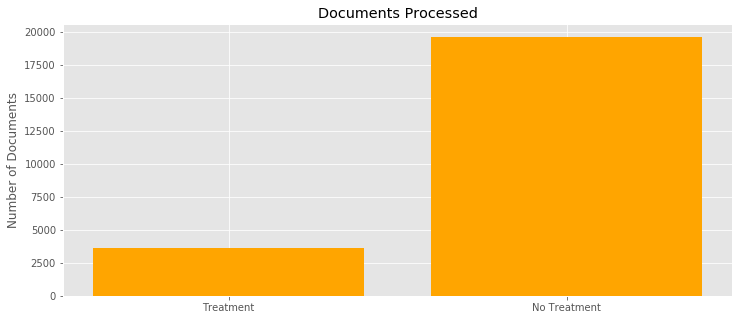

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = ['Treatment', 'No Treatment']
documents = [len(tl_files), len(nt_files)]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, documents, color='orange')
plt.ylabel("Number of Documents")
plt.title("Documents Processed")

fig = plt.gcf()
fig.set_size_inches(12,5)

plt.xticks(x_pos, x)

plt.show()

### Distribution of Trigger Language
A document consists of multiple paragraphs represented by &lt;lnvxe:text&gt; element. Trigger language may span multiple paragraphs. To capture trigger language across multiple paragraphs, a group identifier is used to bundle treatment language fragments - e.g. BL01666283.XML

<laaa:treatmentTrigger groupIdentifier="I7SGF01" guid="I5KS01" totalFragments="2" fragmentNumber="1">

There may also be instances when multiple fragments may appear within a &lt;lnvxe:text&gt; element - e.g. BL01258142.XML

A given document may have more than one group of trigger language.

Text(0.5, 1.0, 'Distribution of Trigger Language Groups')

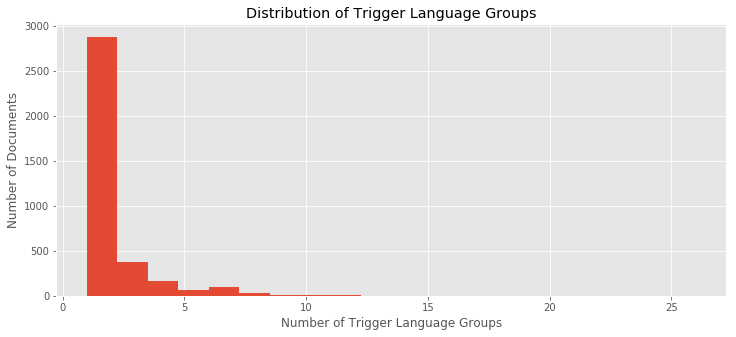

In [11]:
df_group = df.query('trgr_language != ""').groupby(['filename'])['group_id'].agg('nunique').to_frame('group_count')
hist = df_group.hist(column="group_count", bins=20, figsize=(12,5))
hist[0][0].set_ylabel('Number of Documents')
hist[0][0].set_xlabel('Number of Trigger Language Groups')
hist[0][0].set_title('Distribution of Trigger Language Groups')

In [13]:
df_group = df.query('trgr_language != ""').groupby(['group_id'])['fragment_id'].agg('max').to_frame('fragment_count').astype('float64')
hist = df_group.hist(column="fragment_count", bins=40, figsize=(12,6))
hist[0][0].set_ylabel('Number of Triger Language Groups')
hist[0][0].set_xlabel('Number of Fragments')
hist[0][0].set_title('Distribution of Triger Language Fragments')

df0 = df.query('group_id != ""').groupby(['group_id'])['para_id'].agg('min').astype(float).to_frame('para_min').reset_index()
df1 = df.query('group_id != ""').groupby(['group_id'])['para_id'].agg('max').astype(float).to_frame('para_max').reset_index()
df2 = df.query('group_id != ""').groupby(['group_id'])['fragment_id'].agg('max').astype(float).to_frame('fragments').reset_index()
df_span = df0
df_span['para_max'] = df1['para_max']
df_span['span'] = df_span['para_max'] - df_span['para_min'] + 1
df_span['fragments'] = df2['fragments'].astype(float)
df_span.plot.scatter(x='fragments', y='span', title="Scatter Plot: Paragraph span for trigger language group fragments", figsize=(12,6));

In [14]:
trgr_data = pd.DataFrame(df.query('trgr_language != ""'))
trgr_data["language_size"] = trgr_data["trgr_language"].str.len()
size_data = trgr_data.groupby(['group_id'])['language_size'].agg('sum').to_frame('language_size')
hist = size_data.hist(column="language_size", bins=40, figsize=(12,6))
hist[0][0].set_ylabel('Number of Trigger Language Groups')
hist[0][0].set_xlabel('Language Size (characters)')
hist[0][0].set_title('Distribution of Trigger Language Size ')

Text(0.5, 1.0, 'Distribution of Trigger Language Size ')

### Distribution of Trigger Language by Editor
Graphs below depict statistics on language size and number of documents processed by each editor

Text(0.5, 0, 'Editor Alias')

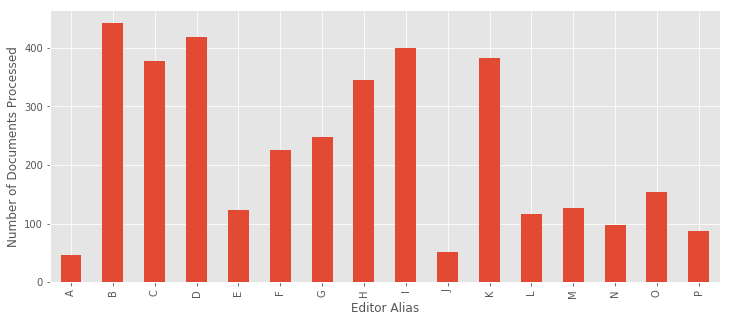

In [15]:
trgr_data = pd.DataFrame(df.query('trgr_language != ""'))
trgr_data["language_size"] = trgr_data["trgr_language"].str.len()
lang_data = trgr_data[['editor_id','language_size', 'group_id']]
size_data = lang_data.groupby(['group_id'])['language_size'].agg('sum').to_frame('language_size')
editor_data = lang_data.groupby(['group_id'])['editor_id'].agg('max').to_frame('editor_id')
editor_data['language_size'] = size_data['language_size']
editor_data = editor_data.reset_index().drop(columns=['group_id']).groupby(['editor_id']).agg(['min','max', 'mean', 'median'])
ax = editor_data.plot.bar(figsize=(12,5), title="Statistics for trigger language group size by Editor")
ax.set_ylabel('Language size (characters)')
ax.set_xlabel('Editor Alias')
doc_data = trgr_data.groupby(['filename'])['editor_id'].agg('max').to_frame().groupby(['editor_id']).size().to_frame('docs')
ax = doc_data.plot.bar(figsize=(12,5), legend=False)
ax.set_ylabel('Number of Documents Processed')
ax.set_xlabel('Editor Alias')

### Ditribution of followed by cites in a document
Some documents have more than 1 citations that are treated with letter 'f'. For example BL01505881.XML has 6 citations that have been followed:

- Mielo v. Steak &apos;n Shake Operations, Inc.
- Hayes v. Wal-Mart Stores, Inc.
- Marcus v. BMW of N. Am., LLC
- In re Modafinil Antitrust Litig.
- Dewey v. Volkswagen Aktiengesellschaft
- In re Modafinil Antitrust Litig.

Text(0.5, 1.0, 'Distribution of FollowedBy Cites ')

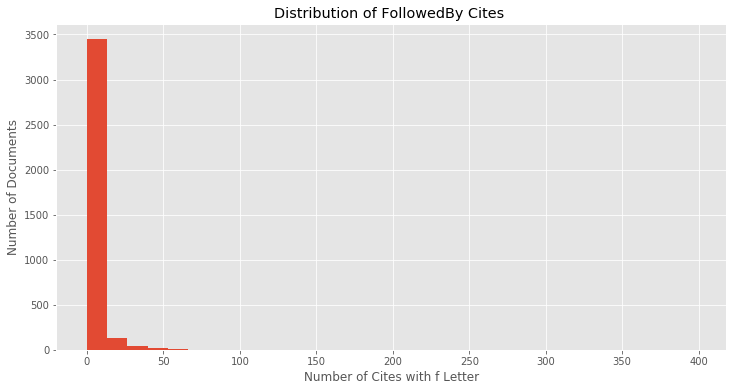

In [16]:
df_group = df.groupby(['filename'])['cnt_f_letter_cite_in_para'].agg('sum').to_frame('cites_with_f_letter')
hist = df_group.hist(column="cites_with_f_letter", bins=30, figsize=(12,6))
hist[0][0].set_ylabel('Number of Documents')
hist[0][0].set_xlabel('Number of Cites with f Letter')
hist[0][0].set_title('Distribution of FollowedBy Cites ')

### Ditribution of followed by cites outside paragraphs with trigger language
Some citations with followed by letter appear outside of paragraphs that have trigger language e.g. BL01258142.XML

Text(0.5, 1.0, 'Distribution of FollowedBy Cites outside paragraphs with trigger language ')

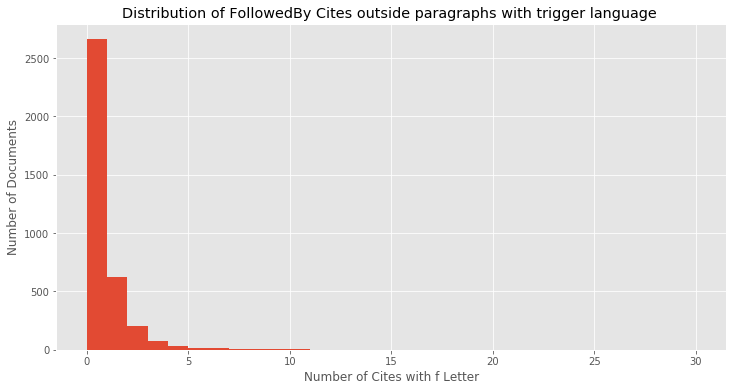

In [17]:
df_group = df.query('trgr_language == ""').groupby(['filename'])['cnt_f_letter_cite_in_para'].agg('sum').to_frame('cites_with_f_letter')
hist = df_group.hist(column="cites_with_f_letter", bins=30, figsize=(12,6))
hist[0][0].set_ylabel('Number of Documents')
hist[0][0].set_xlabel('Number of Cites with f Letter')
hist[0][0].set_title('Distribution of FollowedBy Cites outside paragraphs with trigger language ')

### Visualization of  cite infromation and trigger language embedded within a para 
Trigger language has reference to cites as shown in the xml below. 

<laaa:treatmentTriggerCiteReference ID="I5VW15DW2N1R7H0JK0000400"/>

Actual cite element (or anaphoric reference to cite) corresponding to ID may be in the same para as trigger language or it could be in another para.

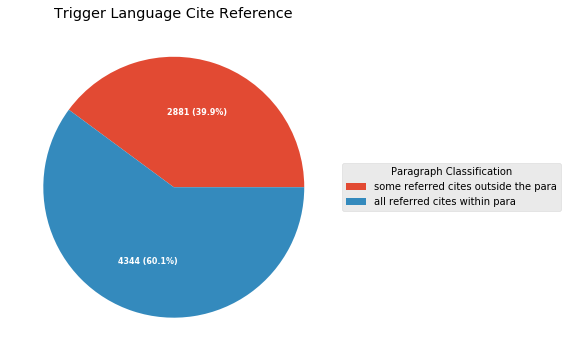

In [18]:
import matplotlib.pyplot as plt
import numpy as np

columns = ['cnt_cite_in_para', 'cnt_cite_referenced', 'cnt_cite_referenced_in_para', 'cnt_f_letter_cite_in_para', 'cnt_nonf_letter_cite_in_para']
df0 = df.groupby(['filename','para_id'])[columns[0]].agg('max').astype(float).to_frame(columns[0]).reset_index()
df1 = df.groupby(['filename','para_id'])[columns[1]].agg('sum').astype(float).to_frame(columns[1]).reset_index()
df2 = df.groupby(['filename','para_id'])[columns[2]].agg('sum').astype(float).to_frame(columns[2]).reset_index()
df3 = df.groupby(['filename','para_id'])[columns[3]].agg('sum').astype(float).to_frame(columns[3]).reset_index()
df4 = df.groupby(['filename','para_id'])[columns[4]].agg('sum').astype(float).to_frame(columns[4]).reset_index()
df_cite_counts = df0
df_cite_counts[columns[1]] = df1[columns[1]]
df_cite_counts[columns[2]] = df2[columns[2]]
df_cite_counts[columns[3]] = df3[columns[3]]
df_cite_counts[columns[4]] = df4[columns[4]]
cnt_partial_ref  = df_cite_counts.query('cnt_cite_referenced != 0 and cnt_cite_referenced != cnt_cite_referenced_in_para')
cnt_complete_ref = df_cite_counts.query('cnt_cite_referenced != 0 and cnt_cite_referenced == cnt_cite_referenced_in_para')

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

data = [len(cnt_partial_ref.index), len(cnt_complete_ref.index)]
lbls = ['some referred cites outside the para', 'all referred cites within para']

def func(percent, vals):
    absolute = int(percent/100.0 * np.sum(vals))
    return "{:d} ({:.1f}%) ".format(absolute, percent)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, lbls,
          title="Paragraph Classification",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Trigger Language Cite Reference")

plt.show()

### Sample Query for finding documents with trigger language and no f letter cites within para

In [17]:
df_group = df.query('trgr_language != ""').groupby(['filename'])['cnt_f_letter_cite_in_para'].agg('sum').to_frame('cites_with_f_letter')
df_group.query('cites_with_f_letter == 0').reset_index().head()

filename  cites_with_f_letter
0  BL01258142.XML                    0
1  BL01262550.XML                    0
2  BL01408914.XML                    0
3  BL01565589.XML                    0
4  BL01606670.XML                    0

### Export to csv

In [150]:
columns = ['filename', 
           'para_id', 
           'para_text', 
           'trgr_language', 
           'group_id', 
           'fragment_id', 
           'editor_id', 
           'cites_in_para',
           'cnt_cite_in_para', 
           'cnt_cite_in_para_anaphref', 
           'cnt_f_letter_cite_in_para', 
           'cnt_nonf_letter_cite_in_para',
           'cnt_cite_referenced',
           'cnt_cite_referenced_in_para']

df.to_csv(r'\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\Analysis\followedbytriggerlanguage.csv', columns=columns, index=False)

In [111]:
df.query('group_id == "I1G45D165GR0007VN3400001"')[['para_text', 'trgr_language']].values.tolist()

[['The Court held a hearing on February 7, 2019, which was attended by counsel for Plaintiffs and counsel for FL 5019 LLC and Chilogistics LLC. Defendants Hammad Enterprises Inc. and Amjad Hammad were noticed and did not appear at the hearing. Defendants Hammad Enterprises Inc. Amjad Hammad have not formally responded to the Motion, nor have they made any appearance or other filing in this case. During the hearing, Plaintiffs directed the Court to evidence supporting the Motion for Preliminary Injunction. Because Plaintiffs have satisfied the requirements for the issuance of a preliminary injunction, the Court grants the Motion.',
  'Plaintiffs have satisfied the requirements for the issuance of a preliminary injunction'],
 ['To obtain a preliminary injunction, a party must demonstrate "(1) a substantial likelihood of success on the merits; (2) that irreparable injury will be suffered if the relief is not granted; (3) that the threatened injury outweighs the harm the relief would infli

In [18]:
import json

xstr = lambda s: s or ""

def cite_dict(cites):
    cites = [] if not cites else cites
    return [{'id':c[0], 'letter':xstr(c[1]), 'anaphoric_id':xstr(c[2]), 'descr':xstr(c[3])} for c in cites]
    
def para_dict(l):
    return {'para':l[0], 'lang':l[1], 'cite_ref':l[2], 'cites':cite_dict(l[3])}

filename = 'BL01430577.XML'
filename = 'BL00085752.XML'

query = 'filename == "{}"'.format(filename)
index = ['para_id','group_id']
columns = ['para_id','group_id','para_text', 'trgr_language', 'cite_referenced', 'cites_in_para']
data = df.query(query)[columns].set_index(index).T.to_dict('list')
data = {':'.join(map(str,k)):para_dict(v) for k,v in data.items()} 
jstr = json.loads(json.dumps(data))

print('data={}'.format(jstr))

data={'0:': {'para': 'THIS OPINION IS SUBJECT TO FORMAL REVISION BEFORE PUBLICATION IN THE ADVANCE SHEETS OF THE SOUTHERN REPORTER.', 'lang': '', 'cite_ref': '', 'cites': []}, '1:': {'para': '(Jefferson Circuit Court, CC-09-3202; Court of Criminal Appeals, CR-10-1343).', 'lang': '', 'cite_ref': '', 'cites': []}, '2:': {'para': 'REVERSED AND REMANDED WITH DIRECTIONS.', 'lang': '', 'cite_ref': '', 'cites': []}, '3:': {'para': 'SELLERS, Justice.', 'lang': '', 'cite_ref': '', 'cites': []}, '4:': {'para': 'Anthony Lane was convicted in the Jefferson Circuit Court of murder made capital because it was committed during the course of a robbery in the first degree. See § 13A-5-40(a)(2), Ala. Code 1975. Although Lane initially lied to police about his involvement in the murder, he eventually told police that he had approached Frank Wright at a car wash to ask him the time, that Wright had used a degrading racial epithet to describe Lane, and that Lane had "blanked out" and shot Wright multiple t

### Create list of documents with large language size

In [19]:
trgr_data = pd.DataFrame(df.query('trgr_language != ""'))
trgr_data["language_size"] = trgr_data["trgr_language"].str.len()
lang_data = trgr_data.groupby(['filename','group_id'])['language_size'].agg('sum').to_frame('language_size')
file_list = list(set(lang_data.query('language_size > 1000').reset_index()['filename'].values.T.tolist()))

### Display document from the list

In [20]:
from ipywidgets import widgets
from IPython.core.display import display, HTML
import json

xstr = lambda s: s or ""

def cite_dict(cites):
    cites = [] if not cites else cites
    return [{'id':c[0], 'letter':xstr(c[1]), 'anaphoric_id':xstr(c[2]), 'descr':xstr(c[3])} for c in cites]
    
def para_dict(l):
    return {'para':l[0], 'lang':l[1], 'cite_ref':l[2], 'cites':cite_dict(l[3])}

def build_document(filename):
    query = 'filename == "{}"'.format(filename)
    index = ['para_id','group_id']
    columns = ['para_id','group_id','para_text', 'trgr_language', 'cite_referenced', 'cites_in_para']
    data = df.query(query)[columns].set_index(index).T.to_dict('list')
    data = {':'.join(map(str,k)):para_dict(v) for k,v in data.items()} 
    jstr = json.loads(json.dumps(data))
    with open('./js/case/data.js', 'w') as f:
        f.write('data={}'.format(jstr))

w = widgets.Dropdown(
    options=['--Select--'] + file_list
)

def on_select(descriptor):
    if descriptor['type'] == 'change' and descriptor['name'] == 'value':
        widget = descriptor['owner']
        if widget.value != widget.options[0]:
            build_document(widget.value)

w.observe(on_select)

display(w)

display(HTML('<button type="Button" onclick=window.open("./html/cite-analysis.html");>Display Document</button>'))    


Dropdown(options=('--Select--', 'BL98378336.XML', 'BL06735375.XML', 'BL04085140.XML', 'BL03831841.XML', 'BL002…

C:\COTS\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:18: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [166]:
items = [1, 2, 3, 4, 5]
squared = dict(map(lambda x: (str(x), x), items))
squared

{'1': 1, '2': 2, '3': 3, '4': 4, '5': 5}

In [184]:
d = {('i', 'j'): ['p','f']}
def para_dict(l):
    return {'para':l[0], 'fragment':l[1]}
squared = {''.join(map(str,k)):para_dict(v) for k,v in d.items()}
squared

{'ij': {'para': 'p', 'fragment': 'f'}}

In [129]:
df.query('fragment_id == "3"').head()

filename  para_id  \
1032  BL01430577.XML       28   
1322  BL01480982.XML       45   
1559  BL01505881.XML      153   
1653  BL01516294.XML       35   
1892  BL01601333.XML      113   

                                                                         para_element  \
1032  <lnvxe:text><laaa:treatmentTrigger createdDate="Mon Apr 22 13:31:54 2019 GMT...   
1322  <lnvxe:text>For the above reasons, we hold that the trial court did not err ...   
1559  <lnvxe:text>Here, Ms. Perez has the requisite minimal degree of knowledge ne...   
1653  <lnvxe:text>P24 <laaa:treatmentTrigger createdDate="Mon Apr 22 21:30:38 2019...   
1892  <lnvxe:text><laaa:treatmentTrigger createdDate="Tue Apr 23 13:20:19 2019 GMT...   

                                                                            para_text  \
1032  We agree with the analysis of the trial judge regarding the points of simila...   
1322  For the above reasons, we hold that the trial court did not err in instructi...   
1559  Here, Ms. Perez has the requisite minimal degree of knowledge necessary. She...   
1653  P24 Recap attempts to distinguish Gravel from this case because the receiver...   
1892  The second consideration looks to whether drawing such lines is even practic...   

                                                                         trgr_element  \
1032  <laaa:treatmentTrigger xmlns:laaa="http://www.w3.org/laaa" xmlns:lnci="http:...   
1322  <laaa:treatmentTrigger xmlns:laaa="http://www.w3.org/laaa" xmlns:lnci="http:...   
1559  <laaa:treatmentTrigger xmlns:laaa="http://www.w3.org/laaa" xmlns:lnci="http:...   
1653  <laaa:treatmentTrigger xmlns:laaa="http://www.w3.org/laaa" xmlns:lnci="http:...   
1892  <laaa:treatmentTrigger xmlns:laaa="http://www.w3.org/laaa" xmlns:lnci="http:...   

                                                                        trgr_language  \
1032  We agree with the analysis of the trial judge regarding the points of simila...   
1322  When read in light of the entire jury instruction and in the context of the ...   
1559  Although she did not comprehend the nuances of the litigation, such lack of ...   
1653  Recap cites no other legal authority supporting its assertion that a special...   
1892                                                The second consideration looks to   

                      group_id fragment_id editor_id  \
1032  I4M9S4V137K000PJDJC00001           3         G   
1322  I5T13NFX8TF000YCGXK00001           3         G   
1559  I4BGPGF81JF000PJP7T00001           3         B   
1653  I7BCPYBVTGF000PJH6300001           3         B   
1892  I6SRC273CNG000GF5WK00001           3         B   

                                                     cites_in_para  \
1032                                                            []   
1322                                                            []   
1559                                                            []   
1653                                                            []   
1892  [(I5VXHD0528T4YB07P0000400, None, I5VXHD0528T4YB07F0000400)]   

      cnt_cite_in_para  cnt_cite_in_para_anaphref  cnt_f_letter_cite_in_para  \
1032                 0                          0                          0   
1322                 0                          0                          0   
1559                 0                          0                          0   
1653                 0                          0                          0   
1892                 1                          1                          0   

      cnt_nonf_letter_cite_in_para  cnt_cite_referenced  \
1032                             0                    1   
1322                             0                    1   
1559                             0                    1   
1653                             0                    1   
1892                             0                    1   

      cnt_cite_referenced_in_para  
1032                            0  
1322   

In [46]:
df.query('filename == "BL00085752.XML"')

filename  para_id  \
0   BL00085752.XML        0   
1   BL00085752.XML        1   
2   BL00085752.XML        2   
3   BL00085752.XML        3   
4   BL00085752.XML        4   
5   BL00085752.XML        5   
6   BL00085752.XML        6   
7   BL00085752.XML        7   
8   BL00085752.XML        8   
9   BL00085752.XML        9   
10  BL00085752.XML       10   
11  BL00085752.XML       11   
12  BL00085752.XML       12   
13  BL00085752.XML       13   
14  BL00085752.XML       14   
15  BL00085752.XML       15   
16  BL00085752.XML       16   
17  BL00085752.XML       17   
18  BL00085752.XML       18   
19  BL00085752.XML       19   
20  BL00085752.XML       20   
21  BL00085752.XML       21   
22  BL00085752.XML       22   
23  BL00085752.XML       23   
24  BL00085752.XML       24   
25  BL00085752.XML       25   
26  BL00085752.XML       26   
27  BL00085752.XML       27   
28  BL00085752.XML       28   
29  BL00085752.XML       29   
30  BL00085752.XML       30   
31  BL00085752.XML       31   
32  BL00085752.XML       32   
33  BL00085752.XML       33   
34  BL00085752.XML       34   
35  BL00085752.XML       35   
36  BL00085752.XML       36   
37  BL00085752.XML       37   
38  BL00085752.XML       38   
39  BL00085752.XML       39   
40  BL00085752.XML       40   
41  BL00085752.XML       41   
42  BL00085752.XML       42   
43  BL00085752.XML       43   
44  BL00085752.XML       44   
45  BL00085752.XML       45   
46  BL00085752.XML       46   
47  BL00085752.XML       47   
48  BL00085752.XML       48   
49  BL00085752.XML       49   
50  BL00085752.XML       50   
51  BL00085752.XML       51   
52  BL00085752.XML       52   
53  BL00085752.XML       53   
54  BL00085752.XML       54   
55  BL00085752.XML       55   

                                                                       para_element  \
0   <lnvxe:text>THIS OPINION IS SUBJECT TO FORMAL REVISION BEFORE PUBLICATION IN...   
1   <lnvxe:text><page count="1" resourcekey="urn:citationForThisResource:611MRTY...   
2                   <lnvxe:text>REVERSED AND REMANDED WITH DIRECTIONS.</lnvxe:text>   
3   <lnvxe:text><lnvxe:judge id="id120">SELLERS</lnvxe:judge>, Justice.</lnvxe:t...   
4   <lnvxe:text>Anthony Lane was convicted in the Jefferson Circuit Court of mur...   
5   <lnvxe:text>Lane parked Wright&apos;s vehicle in an alley next to a convenie...   
6   <lnvxe:text>Before he was sentenced, Lane argued to the trial court that he ...   
7   <lnvxe:text>The Court in <emph typestyle="un">Atkins v. Virginia</emph> used...   
8   <lnvxe:text>On October 5, 2015, the United States Supreme Court granted Lane...   
9   <lnvxe:text>In <emph typestyle="un">Atkins</emph>, the United States Supreme...   
10  <lnvxe:text>According to the Supreme Court in <emph typestyle="un">Atkins</e...   
11  <lnvxe:text>The Court in <emph typestyle="un">Atkins</emph> pointed to the n...   
12  <lnvxe:text>It is undisputed that Lane has an IQ of 70. The State has never ...   
13  <lnvxe:text>It also has not been seriously disputed that Lane&apos;s subaver...   
14  <lnvxe:text>In <lnci:cite ID="I5VVTN3X2D6N0X02J0000400" citedresourcetype="j...   
15  <lnvxe:text>"The question<page count="6" resourcekey="urn:citationForThisRes...   
16  <lnvxe:text><lnci:cite ID="I5VVTN3X2D6N0X02V0000400" anaphref="I5VVTN3X2D6N0...   
17  <lnvxe:text>"If the States were to have complete autonomy to define intellec...   
18  <lnvxe:text><lnci:cite ID="I5VVTN3X2D6N0X0350000400" anaphref="I5VVTN3X2D6N0...   
19  <lnvxe:text>In addition to Florida, the United States Supreme Court in <emph...   
20  <lnvxe:text>As for Lane, however, the Court of Criminal Appeals determined t...   
21  <lnvxe:text>"<emph typestyle="un">Hall</emph> is not as broad as Lane conten...   
22  <lnvxe:text><lnci:cite ID="I5VVTN3X2D6N0X0430000400" anaphref="I5W81J1B1XJH4...   
23  <lnvxe:text>Because the United States Supreme Court did not provide any guid...   
24  <lnvxe:text>Intellectual disability must be proven by a prepond